**Задача:**
    
    - построить модель регрессии, дерево решений, 
    - оптимизировать параметры и сравнить результаты.

Поскольку мы используем boston, то у него логичнее применять именно линейную регрессию.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
import pandas as pd
from sklearn.linear_model import LinearRegression 
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
boston = load_boston()
X_boston = pd.DataFrame(boston.data, columns=boston.feature_names)
y_boston = pd.DataFrame(boston.target, columns=['MEDV'])
boston_df = pd.concat([X_boston,y_boston], axis=1)

In [5]:
X = boston_df[['LSTAT','RM', 'PTRATIO']]
Y = boston_df['MEDV']

In [6]:
X_cut = boston_df[['LSTAT', 'PTRATIO']]

In [7]:
Y.describe()

count    506.000000
mean      22.532806
std        9.197104
min        5.000000
25%       17.025000
50%       21.200000
75%       25.000000
max       50.000000
Name: MEDV, dtype: float64

In [8]:
def get_score(X,y, random_seed=42, model=None):
  if model is None:
    model = LinearRegression()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed )  
  model.fit(X_train, y_train)
  return model.score(X_test, y_test)

Сразу применяем Dummies (для реализации метода One Hot) для данных в Х

In [15]:
def get_one_hot(X, cols):
    for each in cols:
        dummies = pd.get_dummies(X[each], prefix=each, drop_first=False)
        X = pd.concat([X, dummies], axis=1)
    return X

In [9]:
X_full = boston_df.drop(['MEDV'], axis=1)

In [16]:
X_hot = get_one_hot(X_full, X_full)
X_hot.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,LSTAT_30.62,LSTAT_30.63,LSTAT_30.81,LSTAT_31.99,LSTAT_34.02,LSTAT_34.37,LSTAT_34.41,LSTAT_34.77,LSTAT_36.98,LSTAT_37.97
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,0,0,0,0,0,0,0,0,0,0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,0,0,0,0,0,0,0,0,0,0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,0,0,0,0,0,0,0,0,0,0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,0,0,0,0,0,0,0,0,0,0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,0,0,0,0,0,0,0,0,0,0


Проверим качество без Dummies:

In [11]:
get_score(X_full,Y)

0.7112260057484903

Проверим качество с Dummies:

In [17]:
get_score(X_hot,Y)

0.791332762428727

Качество с Dummies  для линейной регрессии выше

**А теперь попробуем с Decision Tree**

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics 

In [24]:
clf = DecisionTreeClassifier(max_depth=100)

Поскольку у нам нужна классификационная модель, а изначально в столбце MEDV идут разные значения, то я решил перевести данные в классы на основе перцентилей

In [25]:
Y_n = np.where(Y <= 20, 'low', Y)
Y_n = np.where((Y > 20 )&(Y <= 50), 'medium', Y)
Y_n = np.where(Y > 50 , 'high', Y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_n, test_size=0.3, random_state=1) # разделяем выборку

In [27]:
clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

In [28]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.013157894736842105


**Очень плохое качество модели. Попробуем применить метод  Decision Tree Regressor**

Причем, сделаем как с Х после One Hot, так и с Х без обработки. Мне просто интересно, будет ли разница.

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [41]:
xtrain, xtest, ytrain, ytest=train_test_split(X_full, Y_n, test_size=0.10)#Создаем новую выборку для обучения Decision Tree Regressor для Х без обработки

In [42]:
xxtrain, xxtest, yytrain, yytest=train_test_split(X_hot, Y_n, test_size=0.10)#Создаем новую выборку для обучения Decision Tree Regressor для Х_hot без обработки

In [47]:
regr = DecisionTreeRegressor(max_depth=3, random_state=1234)
regr.fit(xtrain, ytrain)

DecisionTreeRegressor(max_depth=3, random_state=1234)

In [44]:
regr_hot = regr.fit(xxtrain, yytrain)

Качество модели на тренировочных данных:

In [53]:
score = regr.score(xtrain, ytrain)
print('Качество тренировочной модели с необработанными значениями в Х равно:', score)

Качество модели с необработанными значениями в Х равно: 0.8281449680459065


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [54]:
score_hot = regr_hot.score(xxtrain, yytrain)
print('Качество тренировочной модели с значениями в Х, обработанными методом One Hot, равно:',score_hot)

Качество модели с значениями в Х, обработанными методом One Hot, равно: 0.833525698353939


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Качество модели на тестовых данных:

In [59]:
score_test = regr.score(xtest, ytest)
print('Качество тестовой модели с значениями в Х без обработки, равно:',score_test)

Качество тестовой модели с значениями в Х без обработки, равно: 0.6020489123571053


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [60]:
score_hot_test = regr_hot.score(xxtest, yytest)
print('Качество тестовой модели с значениями в Х, обработанными методом One Hot, равно:',score_hot_test)

Качество тестовой модели с значениями в Х, обработанными методом One Hot, равно: 0.40537585308705015


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


Нуу.... такое....

Визуализируем дерево решений:

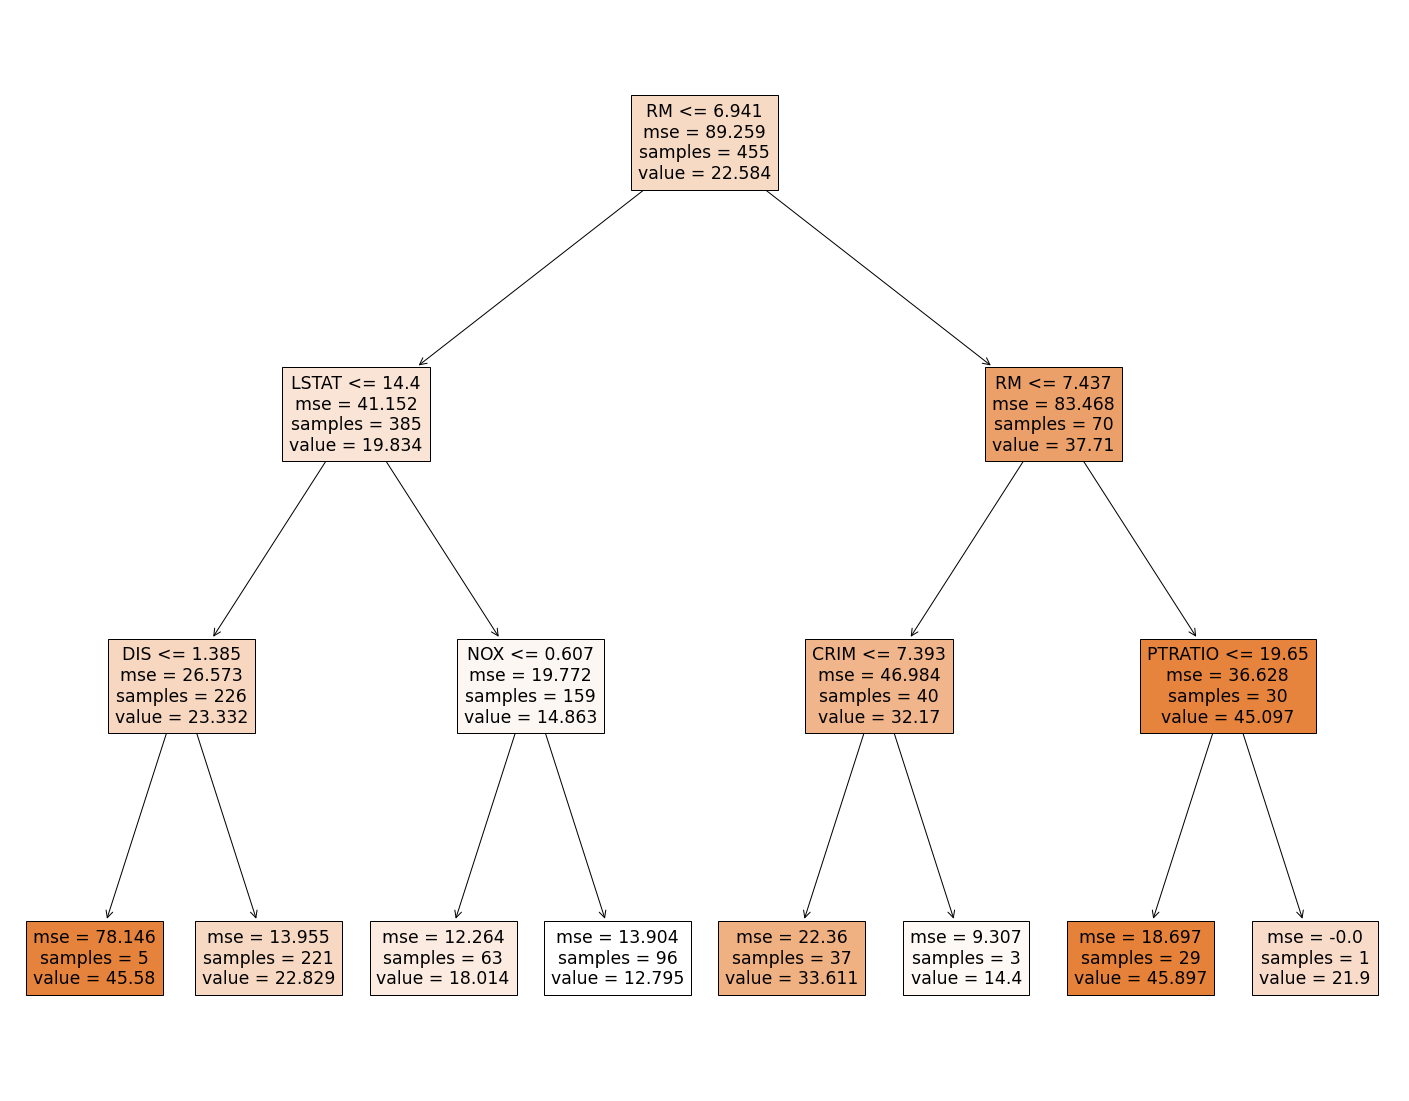

In [62]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(regr, feature_names=boston.feature_names, filled=True)

**Вывод.**

<p>Несмотря на то, что тренировочная модель при Х, обработанном методом One Hot, показала себя лучше, качество тестовой модели с Х без всякой обработки оказалось значительно лучше.</p>
<p>Я правильно понимаю, что здесь налицо яркий пример переобучения?</p>